Github link: https://github.com/dnbabkov/AR_HW_2

In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from geopy.distance import geodesic
from scipy.signal import butter, filtfilt

In [3]:
def generate_noisy_data(n_points=100, trend_slope=0.1, noise_std=0.5):
    x = np.arange(n_points)
    true_y = trend_slope * x
    y = true_y + np.random.normal(0, noise_std, n_points)
    return x, y, true_y

In [47]:
def kalman_filter_1d(measurements, initial_error = 2.0, process_variance = 1.0, measurement_variance = 2.0):
    """
    :param measurements: Список измерений
    :param initial_error: Начальная ошибка ковариации
    :param process_variance: Дисперсия процесса (Q)
    :param measurement_variance: Дисперсия измерения (R)
    :return: Список оценок состояния
    """
    estimates = []
    estimate = measurements[0]  # Начальная оценка как первый элемент массива
    error = initial_error

    for measurement in measurements:
        error += process_variance

        kalman_gain = error / (error + measurement_variance)  # K
        estimate += kalman_gain * (measurement - estimate)  # x = x + K*(z - x)
        error *= (1 - kalman_gain)  # P = (1-K)*P

        estimates.append(estimate)

    return estimates

In [48]:
def recursive_filter(data, alpha=0.2):
    n = len(data)
    x_est = np.zeros(n)
    x_est[0] = data[0]

    for k in range(1, n):
        x_est[k] = alpha * data[k] + (1 - alpha) * x_est[k-1]

    return x_est

In [69]:
x, y, true_y = generate_noisy_data()

kf_result = kalman_filter_1d(y)

rf_result = recursive_filter(y)

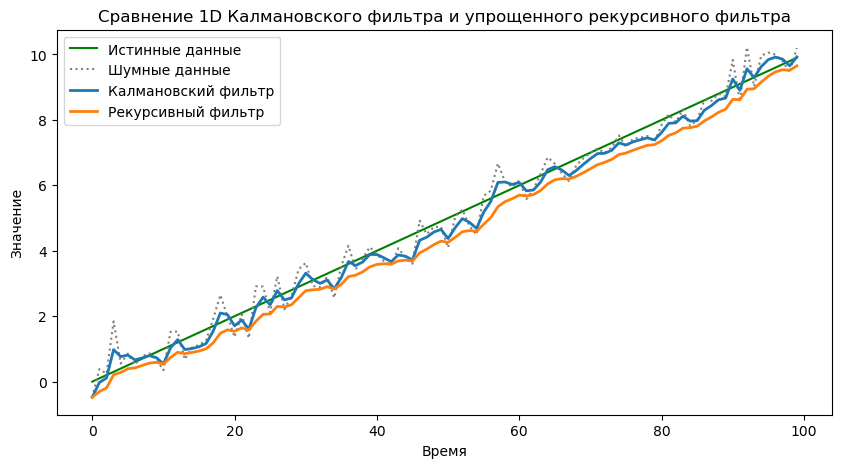

In [53]:
plt.figure(figsize=(10, 5))
plt.plot(x, true_y, label='Истинные данные', linestyle='solid', color='green')
plt.plot(x, y, label='Шумные данные', linestyle='dotted', color='gray')
plt.plot(x, kf_result, label='Калмановский фильтр', linewidth=2)
plt.plot(x, rf_result, label='Рекурсивный фильтр', linewidth=2)
plt.legend()
plt.xlabel('Время')
plt.ylabel('Значение')
plt.title('Сравнение 1D Калмановского фильтра и упрощенного рекурсивного фильтра')
plt.show()

In [89]:
def load_data(file_path):
    df = pd.read_csv(file_path, delimiter=';', decimal=',', index_col=False)
    df = df.loc[:, ~df.columns.str.contains('^Unnamed')]
    df = df.dropna()
    return df

In [90]:
def compute_distance_gps(df):
    reference = df[(df['Latitude'] != 0) & (df['Longitude'] != 0)].iloc[0]
    ref_point = (reference['Latitude'], reference['Longitude'])
    distances = [0]
    
    for i in range(1, len(df)):
        point = (df.iloc[i]['Latitude'], df.iloc[i]['Longitude'])
        dist = geodesic(ref_point, point).meters
        distances.append(dist)
    
    return np.array(distances)

In [91]:
def lowpass_filter(data, cutoff=0.3, fs=50, order=4):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return filtfilt(b, a, data)

def compute_distance_acceleration(df):
    dt = np.gradient(df['time'].values)
    
    # Берем только горизонтальное ускорение (x, y)
    acc_x = df['ax'].values
    acc_y = df['ay'].values
    acc_magnitude = np.sqrt(acc_x**2 + acc_y**2)  # Убираем z, т.к. он включает гравитацию
    acc_filtered = lowpass_filter(acc_magnitude)  # Фильтруем шум
    
    # Интегрируем ускорение -> скорость
    velocity = np.cumsum(acc_filtered * dt)
    velocity -= np.mean(velocity[:10])  # Коррекция нулевой скорости
    velocity[velocity < 0] = 0  # Убираем отрицательную скорость
    
    # Интегрируем скорость -> расстояние
    distance = np.cumsum(velocity * dt)
    return distance

In [92]:
file_path = './AR-HW2-Dataset.csv'
df = load_data(file_path)
df

,time,ax,ay,az,Latitude,Longitude,Speed (m/s),Altitude (m)
0,0.036971,0.0000,0.0000,0.0000,0.000000,0.000000,0.000000,210.6
1,0.046745,0.0000,0.0000,0.0000,55.752963,48.743988,0.122504,210.6
2,0.047770,0.9798,-0.7944,0.2223,55.752963,48.743988,0.122504,210.6
3,0.056407,0.9798,-0.7944,0.2223,55.752963,48.743988,0.122504,210.6
4,0.066267,0.9798,-0.7944,0.2223,55.752963,48.743988,0.122504,210.6
...,...,...,...,...,...,...,...,...
29816,193.690218,-0.2771,0.3649,0.6737,55.750920,48.743622,1.375852,195.2
29817,193.698870,-0.2771,0.3649,0.6737,55.750920,48.743622,1.375852,195.2
29818,193.708511,-0.2771,0.3649,0.6737,55.750920,48.743622,1.375852,195.2
29819,193.709219,-0.3744,0.3899,0.7971,55.750920,48.743622,1.375852,195.2


In [93]:
gps_distance = compute_distance_gps(df)
gps_distance

array([  0.        ,   0.        ,   0.        , ..., 228.66089653,
       228.66089653, 228.66089653])

In [94]:
acc_distance = compute_distance_acceleration(df)
acc_distance

array([1.00786992e-06, 1.32353161e-06, 1.45124466e-06, ...,
       7.99369012e+03, 7.99418965e+03, 7.99512945e+03])

In [95]:
std_acc = np.std(acc_distance)
std_meas = np.std(gps_distance)

In [96]:
filtered_distance = kalman_filter_1d(gps_distance, std_acc, std_meas)

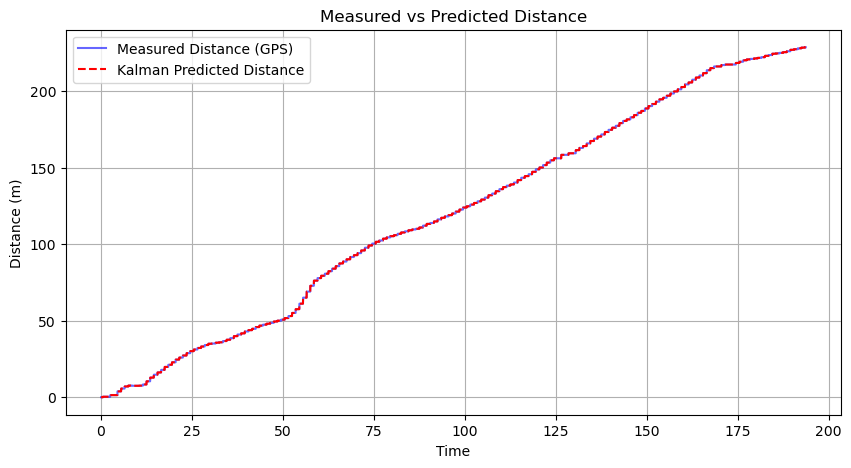

In [98]:
time = df['time'].values
plt.figure(figsize=(10, 5))
plt.plot(time, gps_distance, label='Measured Distance (GPS)', color='blue', alpha=0.6)
plt.plot(time, filtered_distance, label='Kalman Predicted Distance', color='red', linestyle='--')
plt.xlabel('Time')
plt.ylabel('Distance (m)')
plt.title('Measured vs Predicted Distance')
plt.legend()
plt.grid()
plt.show()

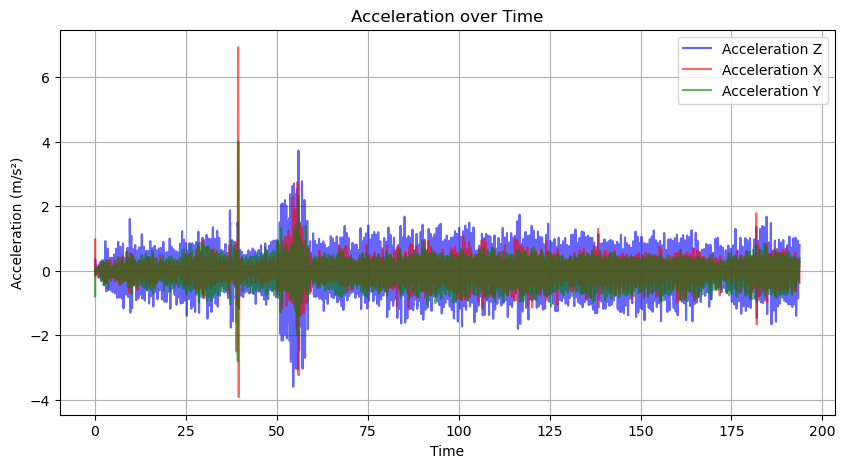

In [100]:
# Визуализация ускорений
plt.figure(figsize=(10, 5))
plt.plot(time, df['az'], label='Acceleration Z', color='blue', alpha=0.6)
plt.plot(time, df['ax'], label='Acceleration X', color='red', alpha=0.6)
plt.plot(time, df['ay'], label='Acceleration Y', color='green', alpha=0.6)
plt.xlabel('Time')
plt.ylabel('Acceleration (m/s²)')
plt.title('Acceleration over Time')
plt.legend()
plt.grid()
plt.show()